# Portfolio optimisation

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy.stats as stats

In [139]:
class Portfolio:
    def __init__(self, tickers=None, start=None, end=None, trading_days = 250):
        """
        Generate a portfolio from a list of tickers.
        .rawdata: {'Adj Close','Close','High','Low','Open','Volume'}
        -------------------
        tickers = []
        {start, end} = datetime
        trading_days = number of trading days in the year
        -------------------
        Defaults:
        Ticker: ^FTSE, Vodafone
        Start: 52 weeks from current date
        End: Current date
        -------------------
        Uses yahoo_finance
        """
# Setting default values to generate quick test instances
    # Use FTSE index if no ticker is provided
        if tickers==None:
            self.tickers = ['^FTSE','^GSPC']
            print ('No ticker provided, FTSE and S&P 500 was used')
        else: self.tickers = tickers
    # If no dates specified, use the range from 52 weeks ago till today
        if start==None:
            start = (dt.datetime.today()-dt.timedelta(weeks=52))
            print ('Default start date: {}'.format((dt.datetime.today()-dt.timedelta(weeks=52)).strftime('%d-%m-%y')))
        if end==None:
            end = (dt.datetime.today())
            print ('Default end date: {}'.format((dt.datetime.today()).strftime('%d-%m-%y')))
# Retieve the data from YahooFinance        
        self.raw_data = yf.download(self.tickers, start=start, end=end).dropna()
        self.risk_free_rate = yf.download('^TNX')['Adj Close'].iloc[-1]
# Quick indication of missing date
        print('The data spans {} working days, but has {} observations.'.format(np.busday_count(start.date(),end.date()),len(self.raw_data)))
        self.log_returns = np.log(self.raw_data['Adj Close'] / self.raw_data['Adj Close'].shift(1))
# Functions for creating portfolio returns and volatilities
    def Efficient_Frontier(self, n=1000, s=100):
        portfolio_returns = []
        portfolio_volatilities = []
        for x in range (n):
            weights = np.random.random(len(self.tickers))
            weights /= np.sum(weights)
            portfolio_returns.append(np.sum(weights * self.log_returns.mean())*250)
            portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(self.log_returns.cov() * 250, weights))))
        self.portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities})
        plt.figure(figsize=(10,4))
        plt.scatter(x=self.portfolios['Volatility'],y=self.portfolios['Return'],s=s)
        plt.xlabel("Volatility")
        plt.ylabel("Return")
    def equally_weighted(self):
        self.weights = np.ones(len(self.tickers))/len(self.tickers)
        self.portfolio_prices = Port_ret(self.weights, self.raw_data['Adj Close'])
        self.portfolio_return = Port_ret(self.weights, self.log_returns)
        self.portfolio_volatility = Port_vol(self.weights, self.log_returns)
    def randomly_weighted(self):
        self.weights = np.random.random(len(tickers))
        self.weights /= np.sum(self.weights)
        self.portfolio_prices = Port_ret(self.weights, self.raw_data['Adj Close'])
        self.portfolio_return = Port_ret(self.weights, self.log_returns)
        self.portfolio_volatility = Port_vol(self.weights, self.log_returns)
        
def Port_ret(weights, log_returns, trading_days=None):
    if trading_days != None:
        return (np.sum(weights * log_returns.mean()) * trading_days)
    else: return (np.sum(weights * log_returns,axis=1))
def Port_vol(weights, log_returns, trading_days=None):
    if trading_days != None:
        return (np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * trading_days, weights))))
    else: return (np.sqrt(np.dot(weights.T,np.dot(log_returns.cov(), weights))))

In [140]:
start = dt.datetime(2004,1,1)
port1 = Portfolio(start=start)

No ticker provided, FTSE and S&P 500 was used
Default end date: 16-02-23
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
The data spans 4990 working days, but has 4726 observations.


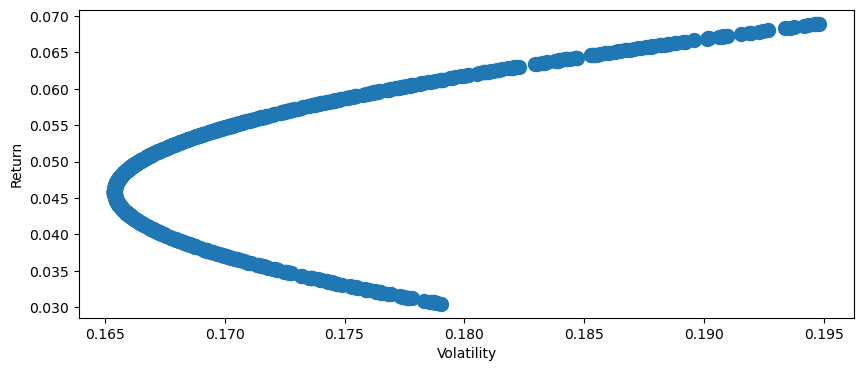

In [141]:
port1.Efficient_Frontier()

In [142]:
port1.equally_weighted()

In [143]:
returns1 = port1.portfolio_return

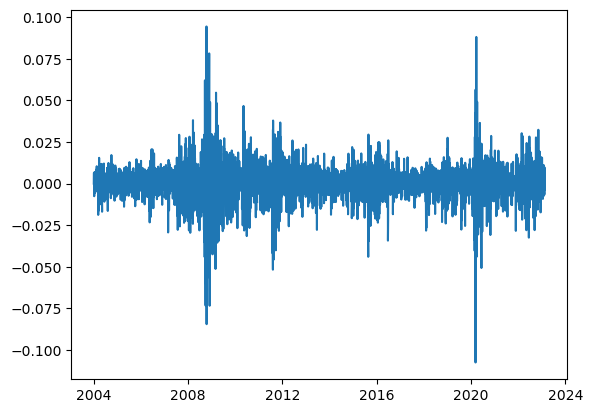

In [144]:
plt.plot(returns1)

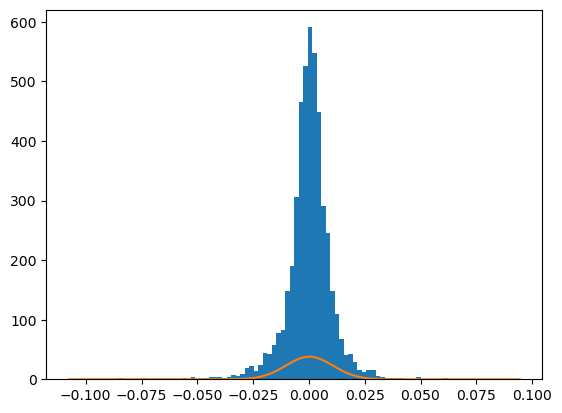

In [145]:
plt.hist(returns1,bins=100)
plt.plot(np.linspace(returns1.values.min(), returns1.values.max(),num=len(returns1)),norm.pdf(np.linspace(returns1.values.min(), returns1.values.max(),num=len(returns1)), returns1.mean(), returns1.std()))
plt.show()

In [146]:
skew = stats.skew(returns1, bias=False)
kurtosis = stats.kurtosis(returns1, bias=False)
print('Skew: {}, Kurtosis: {}'.format(skew,kurtosis))

Skew: -0.5892266197705675, Kurtosis: 12.183097818464548


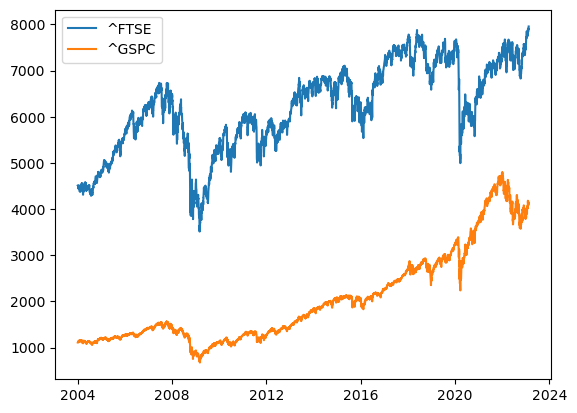

In [147]:
plt.plot(x.raw_data['Adj Close'])
plt.legend(['^FTSE', '^GSPC'])

In [148]:
x.log_returns['^GSPC']

Date
2004-01-02         NaN
2004-01-05    0.012319
2004-01-06    0.001291
2004-01-07    0.002364
2004-01-08    0.004951
                ...   
2023-02-08   -0.011143
2023-02-09   -0.008869
2023-02-10    0.002193
2023-02-13    0.011384
2023-02-14   -0.000280
Name: ^GSPC, Length: 4724, dtype: float64

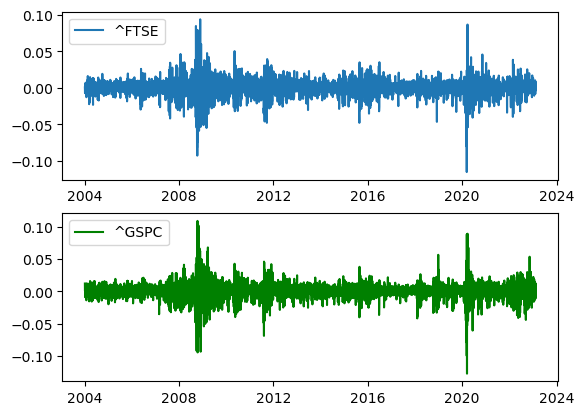

In [149]:
plt.figure()

plt.subplot(2, 1, 1)                            
plt.plot(x.log_returns['^FTSE'])
plt.legend(['^FTSE'])
plt.subplot(2, 1, 2)                               
plt.plot(x.log_returns['^GSPC'],color='g')  
plt.legend(['^GSPC'])
plt.show()

In [23]:
def compute_var(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: percentile of return distribution at a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            return np.percentile(returns, alpha)
        else:
            return returns.rolling(window).apply(lambda x: np.percentile(x,alpha), raw=True).dropna()
            # ALT: returns.rolling(window).quantile(alpha/100)
    else:
        raise TypeError("Expected a pandas data series")

def compute_es(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: Expected shortfall for a given confidence interval alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            belowVaR = returns <= compute_var(returns, alpha=alpha)
            return returns[belowVaR].mean()
        else:
            return returns.rolling(window).apply(lambda x: x[x<= compute_var(x, alpha)].mean()).dropna()
    else:
        raise TypeError("Expected a pandas data series")

In [24]:
var = compute_var(x.portfolio_return, 5, window=50)
es = compute_es(x.portfolio_return, 5, window=50)

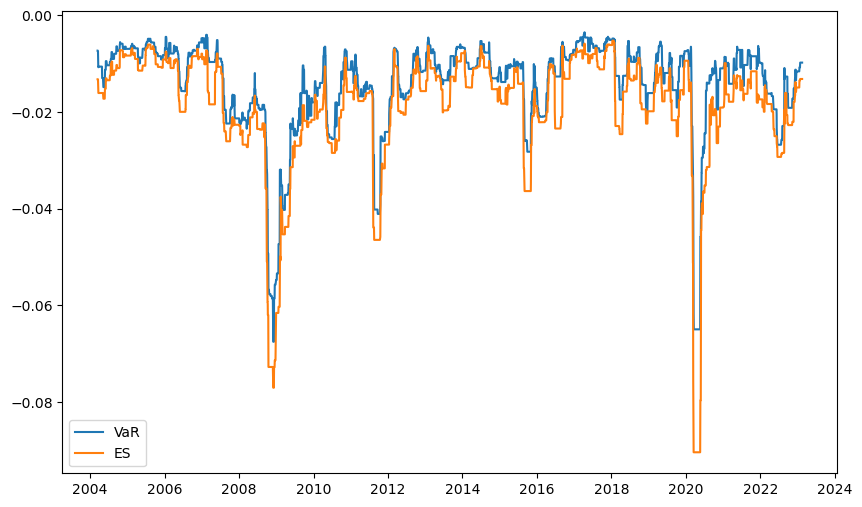

In [322]:
plt.figure(figsize=(10,6))
plt.plot(var, label='VaR')
plt.plot(es, label='ES')
plt.legend()
plt.show()

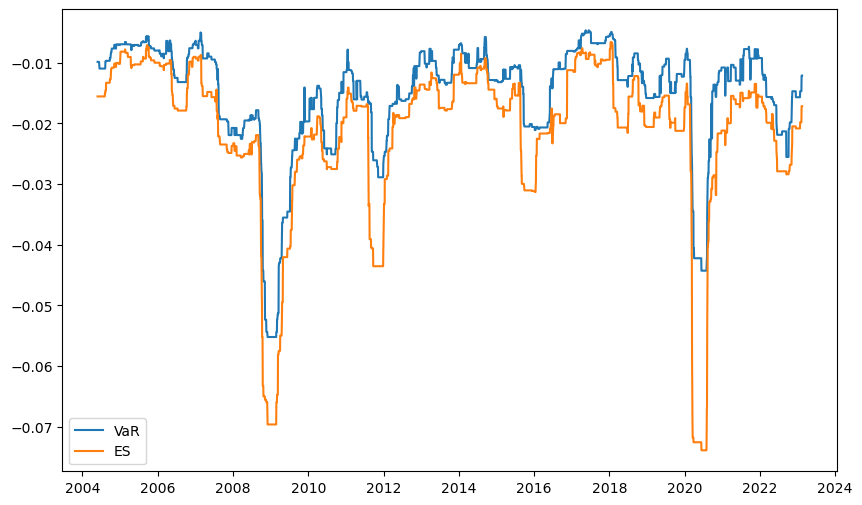

In [314]:
plt.figure(figsize=(10,6))
plt.plot(var, label='VaR')
plt.plot(es, label='ES')
plt.legend()
plt.show()

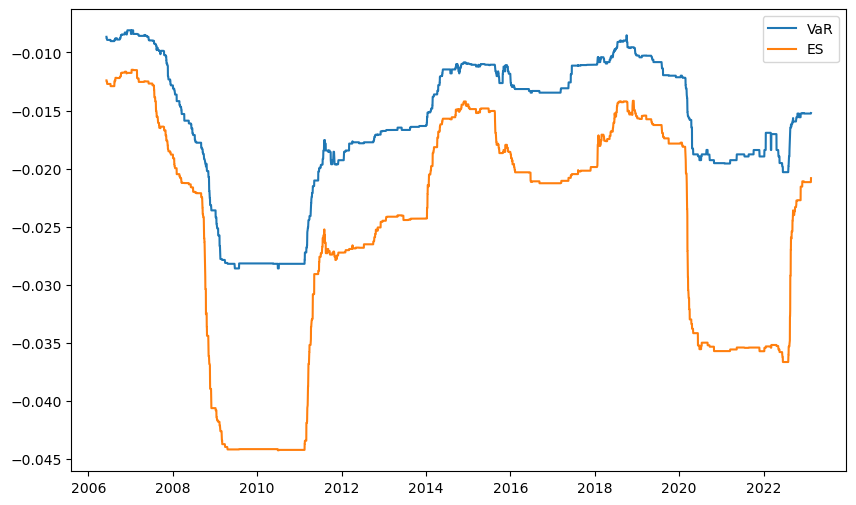

In [316]:
plt.figure(figsize=(10,6))
plt.plot(var, label='VaR')
plt.plot(es, label='ES')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

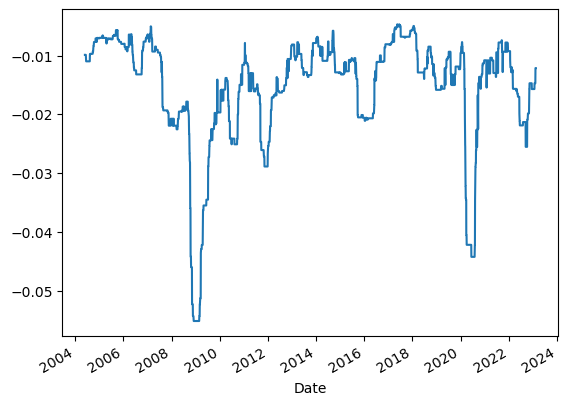

<AxesSubplot:xlabel='Date'>

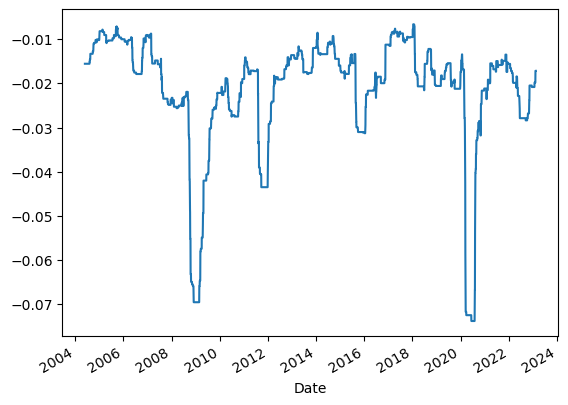

In [213]:
import time

In [200]:
# get the start time
st = time.time()

pp = x.portfolio_return.rolling(10).apply(lambda x: np.percentile(x, 5), raw=True)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds and', pp.mean())

Execution time: 0.28809547424316406 seconds and -0.011359162535289768


In [201]:
# get the start time
st = time.time()

pp = x.portfolio_return.rolling(10).apply(lambda x: np.percentile(x, 5), raw=False)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds and', pp.mean())

Execution time: 0.4959726333618164 seconds and -0.011359162535289768


In [1]:
from risk_management import value_at_risk as var
import timeit
import datetime as dt

In [5]:
x = var.Portfolio(var.tickers['ftse100'], start=dt.datetime(2015,1,1), end=dt.datetime.today())

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
- MGGT.L: No timezone found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
{'RMG.L', 'MGGT.L', 'AUTO'}
3 columns were removed because there were less observations than the threshold (0.8):
AUTO      0
MGGT.L    0
RMG.L     0
dtype: int64
[*********************100%***********************]  1 of 1 completed
The data spans 2121 working days, but has 1960 observations.


In [8]:
len(x.tickers)

98

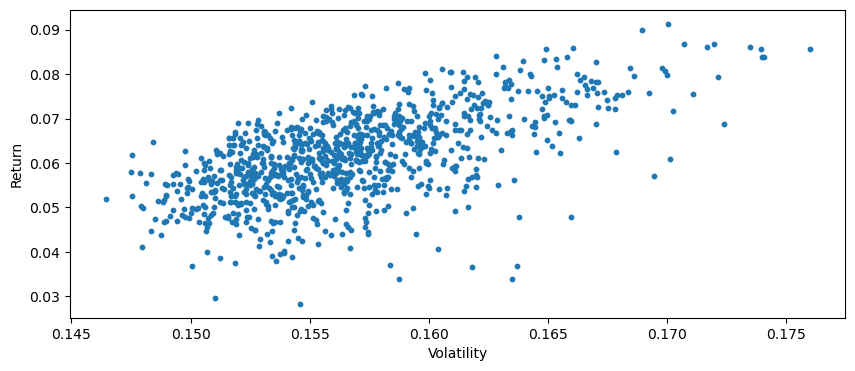

In [3]:
x.Efficient_Frontier()

In [ ]:
portfolio_returns = []
portfolio_volatilities = []
for x in range (100):
    weights = np.random.random(len(self.tickers))
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(weights * self.log_returns.mean())*250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(self.log_returns.cov() * 250, weights))))
self.portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities})
plt.figure(figsize=(10,4))
plt.scatter(x=self.portfolios['Volatility'],y=self.portfolios['Return'],s=20)
plt.xlabel("Volatility")
plt.ylabel("Return")

In [14]:
len(x.tickers)

101

In [29]:
x.equally_weighted()

In [34]:
var.compute_var(x.portfolio_return,1,window=25)

Date
2022-03-25   -0.020551
2022-03-28   -0.020551
2022-03-29   -0.020551
2022-03-30   -0.020551
2022-03-31   -0.020551
                ...   
2023-02-10   -0.009175
2023-02-13   -0.009175
2023-02-14   -0.009175
2023-02-15   -0.009175
2023-02-16   -0.009175
Length: 219, dtype: float64

In [15]:
x.portfolio_return

Date
2022-02-18    0.000000
2022-02-22   -0.006390
2022-02-23   -0.009025
2022-02-24   -0.012382
2022-02-25    0.030288
                ...   
2023-02-10   -0.000721
2023-02-13    0.009804
2023-02-14    0.000256
2023-02-15    0.004137
2023-02-16   -0.006024
Length: 243, dtype: float64

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 08:36:02 2023

@author: JHL
"""
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy.stats as stats

class Portfolio:
    def __init__(self, tickers=None, start=None, end=None, trading_days = 250):
        """
        Generate a portfolio from a list of tickers.
        .rawdata: {'Adj Close','Close','High','Low','Open','Volume'}
        -------------------
        tickers = []
        {start, end} = datetime
        trading_days = number of trading days in the year
        -------------------
        Defaults:
        Ticker: ^FTSE, Vodafone
        Start: 52 weeks from current date
        End: Current date
        -------------------
        Uses yahoo_finance
        -------------------
        example:
        x = Portfolio(tickers= ['LLOY.L','NWG.L','TSL3.L','TSCO.L','BOIL.AQ'], start=dt.datetime(2000,1,1), end=dt.datetime.today())
        """
# Setting default values to generate quick test instances
    # Use FTSE index if no ticker is provided
        if tickers==None:
            self.tickers = ['^FTSE','^GSPC']
            print ('No ticker provided, FTSE and S&P 500 was used')
        else: self.tickers = tickers
    # If no dates specified, use the range from 52 weeks ago till today
        if start==None:
            start = (dt.datetime.today()-dt.timedelta(weeks=52))
            print ('Default start date: {}'.format((dt.datetime.today()-dt.timedelta(weeks=52)).strftime('%d-%m-%y')))
        if end==None:
            end = (dt.datetime.today())
            print ('Default end date: {}'.format((dt.datetime.today()).strftime('%d-%m-%y')))
# Retieve the data from YahooFinance        
        self.raw_data = yf.download(self.tickers, start=start, end=end)
        self.risk_free_rate = yf.download('^TNX')['Adj Close']
# Quick indication of missing date
        print('The data spans {} working days, but has {} observations.'.format(np.busday_count(start.date(),end.date()),len(self.raw_data)))
        self.log_returns = np.log(self.raw_data['Adj Close'] / self.raw_data['Adj Close'].shift(1))
# Functions for creating portfolio returns and volatilities
    def Efficient_Frontier(self, n=1000, s=10):
        portfolio_returns = []
        portfolio_volatilities = []
        for x in range (n):
            weights = np.random.random(len(self.tickers))
            weights /= np.sum(weights)
            portfolio_returns.append(np.sum(weights * self.log_returns.mean())*250)
            portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(self.log_returns.cov() * 250, weights))))
        self.portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities})
        plt.figure(figsize=(10,4))
        plt.scatter(x=self.portfolios['Volatility'],y=self.portfolios['Return'],s=s)
        plt.xlabel("Volatility")
        plt.ylabel("Return")
    def equally_weighted(self):
        self.weights = np.ones(len(self.tickers))/len(self.tickers)
        self.portfolio_prices = portfolio_return(self.weights, self.raw_data['Adj Close'])
        self.portfolio_return = portfolio_return(self.weights, self.log_returns)
        self.portfolio_vol = portfolio_volatility(self.weights, self.log_returns)
    def randomly_weighted(self):
        self.weights = np.random.random(len(tickers))
        self.weights /= np.sum(self.weights)
        self.portfolio_prices = portfolio_return(self.weights, self.raw_data['Adj Close'])
        self.portfolio_return = portfolio_return(self.weights, self.log_returns)
        self.portfolio_vol = portfolio_volatility(self.weights, self.log_returns)
        
def portfolio_return(weights, log_returns, trading_days=None):
    if trading_days != None:
        return (np.sum(weights * log_returns.mean()) * trading_days)
    else: return (np.sum(weights * log_returns,axis=1))
def portfolio_volatility(weights, log_returns, trading_days=None):
    if trading_days != None:
        return (np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * trading_days, weights))))
    else: return (np.sqrt(np.dot(weights.T,np.dot(log_returns.cov(), weights))))
    
    

def compute_var(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: percentile of return distribution at a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            return np.percentile(returns, alpha)
        else:
            return returns.rolling(window).apply(lambda x: np.percentile(x,alpha), raw=True).dropna()
            # ALT: returns.rolling(window).quantile(alpha/100)
    else:
        raise TypeError("Expected a pandas data series")

def compute_es(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: Expected shortfall for a given confidence interval alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            belowVaR = returns <= compute_var(returns, alpha=alpha)
            return returns[belowVaR].mean()
        else:
            return returns.rolling(window).apply(lambda x: x[x<= compute_var(x, alpha)].mean()).dropna()
    else:
        raise TypeError("Expected a pandas data series")

In [8]:
x = Portfolio()

No ticker provided, FTSE and S&P 500 was used
Default start date: 18-02-22
Default end date: 17-02-23
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
The data spans 260 working days, but has 258 observations.


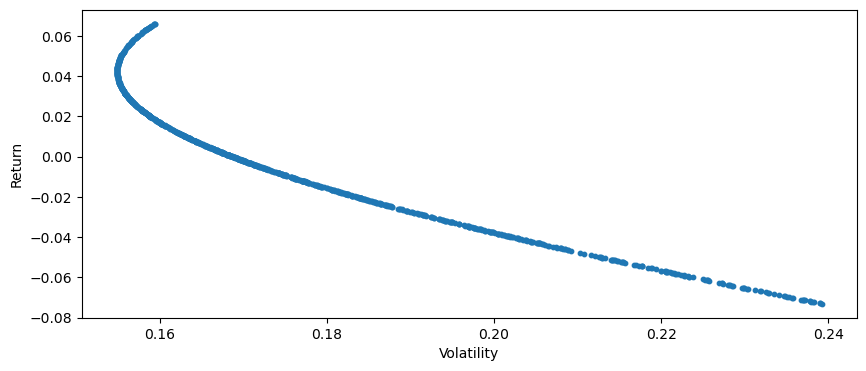

In [9]:
x.Efficient_Frontier()

In [22]:
funcs.column_na(x.raw_data)['Adj Close']

150 columns were removed because there were less observations than the threshold:
Adj Close  AAL       4379
           ABDN.L    4199
           AUTO         0
           BME       4506
           CCH.L     2480
                     ... 
Volume     PHNX.L    3348
           RMG.L        0
           RMV.L     4281
           SKG.L     4026
           SMIN      2775
Length: 150, dtype: int64


,ABF.L,ADM,AHT,ANTO.L,AON,AV.L,AVV.L,AZN,BA.L,BARC.L,...,STJ.L,SVT,TSCO,TW.L,ULVR.L,UTG,UU.L,VOD,WPP,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-25,416.994202,11.099695,235.162918,132.276230,20.265020,197.083939,100.474213,11.606347,81.285126,258.801758,...,104.960396,2.557614,9.165786,107.432709,648.404724,5.275166,184.168228,11.085204,31.815454,560.946533
2004-02-26,414.882690,11.190886,237.547989,130.782761,20.148104,198.137878,100.474213,11.553813,83.601250,255.411972,...,103.514618,2.557614,9.191645,107.432709,647.600159,5.275166,184.168228,10.956802,32.127483,555.385437
2004-02-27,412.419495,11.203918,236.116974,130.356110,20.444283,198.137878,103.035667,11.611128,83.932137,252.282867,...,104.092934,2.557614,9.228283,109.662468,646.680664,5.272530,183.622879,10.687159,30.715166,547.970215
2004-03-01,411.363770,11.275570,243.033569,131.742844,20.592379,201.738815,103.234200,11.833224,86.248276,254.760025,...,104.382088,2.492864,9.327417,112.601677,650.933960,5.275166,186.713577,11.025279,29.943316,549.453064
2004-03-02,412.771393,11.223455,248.042053,133.876343,20.506641,203.495331,103.234200,11.649337,88.454094,255.281555,...,105.654305,2.468583,9.342503,115.540840,644.381165,5.272530,185.259262,10.785598,29.850256,559.092773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-12,1801.500000,86.914246,5.740000,1762.500000,315.312927,451.700012,3218.000000,70.080002,833.200012,177.080002,...,1243.000000,11.510000,220.740005,112.650002,4185.000000,29.986147,1045.500000,11.280000,55.910000,3020.000000
2023-01-13,1795.000000,87.918755,5.830000,1750.500000,316.610657,444.200012,3218.000000,71.080002,832.799988,180.740005,...,1242.500000,10.630000,221.089996,114.750000,4215.500000,30.085505,1037.000000,11.230000,56.689999,3033.000000
2023-01-17,1853.500000,87.610435,5.830000,1741.500000,316.381042,441.799988,3219.000000,70.739998,838.400024,180.940002,...,1251.000000,11.290000,218.990005,117.000000,4165.500000,30.145119,1039.500000,11.420000,56.770000,3028.000000


In [112]:
def column_na(df, threshold=0.8, row_na=True):
    """
    Parameters
    ----------
    df : Any dataframe where some columns have substantial observations missing
    threshold : TYPE, optional
        The default is set to remove columns with less than 80% of total oberservations
    row_na: also removes any rows with missing data for completeness
    
    Returns complete data for analysis
    -------

    """
    names = [x for x in df if df[x].count()<len(df)*threshold]
    print(set([x[1] for x in names]))
    print('{} columns were removed because there were less observations than the threshold ({}):'.format(len(set([x[1] for x in names])),threshold))
    print(df[names].count()['Adj Close'])
    if row_na==True:
        return df.dropna(thresh=len(df)*threshold, axis=1).dropna()
    else: 
        return df.dropna(thresh=len(df)*threshold, axis=1)


In [113]:
column_na(x.raw_data)

{'MGGT.L', 'AUTO', 'CCH.L', 'RMG.L', 'LAND'}
5 columns were removed because there were less observations than the threshold (0.8):
AUTO         0
CCH.L     2480
LAND      2533
MGGT.L       0
RMG.L        0
dtype: int64


Adj Close                                                  \
                  AAL      ABDN.L        ABF.L        ADM         AHT   
Date                                                                    
2012-02-09   8.446963  164.729523  1009.721985  22.808578  348.733887   
2012-02-10   8.343263  161.220078  1015.686890  22.675056  340.255219   
2012-02-13   8.654366  163.225433  1021.651184  22.942085  341.361084   
2012-02-14   8.484674  163.870010  1031.024414  23.236742  329.564667   
2012-02-15   8.380971  165.445709  1037.840820  23.154686  328.090057   
...               ...         ...          ...        ...         ...   
2023-01-12  16.830000  201.100006  1801.500000  86.914246    5.740000   
2023-01-13  17.020000  204.300003  1795.000000  87.918755    5.830000   
2023-01-17  17.080000  207.699997  1853.500000  87.610435    5.830000   
2023-01-18  16.639999  207.500000  1831.000000  84.537262    5.700000   
2023-01-19  16.280001  201.000000  1814.000000  84.845573    5.730000   

                                                                         ...  \
                 ANTO.L         AON        AV.L        AVV.L        AZN  ...   
Date                                                                     ...   
2012-02-09   923.196899   43.324551  204.769791  1102.147461  15.204564  ...   
2012-02-10   906.748230   43.244408  199.954971  1113.059814  15.098909  ...   
2012-02-13   923.882385   43.351276  203.662918  1093.802979  15.252585  ...   
2012-02-14   916.343262   43.003963  200.120941  1091.235229  15.236581  ...   
2012-02-15   909.489380   42.745697  200.895752  1099.579590  15.096365  ...   
...                 ...         ...         ...          ...        ...  ...   
2023-01-12  1762.500000  315.312927  451.700012  3218.000000  70.080002  ...   
2023-01-13  1750.500000  316.610657  444.200012  3218.000000  71.080002  ...   
2023-01-17  1741.500000  316.381042  441.799988  3219.000000  70.739998  ...   
2023-01-18  1799.500000  313.536072  441.000000  3219.000000  70.889999  ...   
2023-01-19  1723.000000  318.397491  436.200012    32.189999  70.489998  ...   

               Volume                                                      \
                STJ.L     SVT       TSCO        TW.L     ULVR.L       UTG   
Date                                                                        
2012-02-09   108210.0  9100.0  1075400.0   5274106.0  1901488.0  127700.0   
2012-02-10   150840.0   800.0   947800.0   5104028.0  2261635.0   99500.0   
2012-02-13   418882.0  5700.0  1088400.0   4999225.0  1891073.0   80400.0   
2012-02-14   255738.0  2900.0   695800.0  13948869.0  1903970.0   70900.0   
2012-02-15   153881.0  6000.0  1273200.0   7777509.0  1726972.0   93000.0   
...               ...     ...        ...         ...        ...       ...   
2023-01-12  2620671.0  1800.0  1053800.0  19115506.0  2967973.0  190800.0   
2023-01-13  2257607.0  6600.0  1371800.0  27034727.0  2805084.0  276300.0   
2023-01-17  1787699.0  7700.0  1201500.0  12126612.0  4060199.0  344800.0   
2023-01-18  4430913.0  7700.0  1079400.0  17066956.0  4991091.0  242100.0   
2023-01-19  2438562.0  1800.0  1187000.0  17626577.0  6022815.0  222400.0   

                                                        
                 UU.L         VOD       WPP      WTB.L  
Date                                                    
2012-02-09  1658461.0   6482252.0  147800.0   622525.0  
2012-02-10  1613756.0   7979062.0  153400.0   673603.0  
2012-02-13  1256337.0   5620443.0   90500.0   583610.0  
2012-02-14  2385606.0  10138341.0   86000.0   393965.0  
2012-02-15  1197129.0   6366788.0   47900.0   345800.0  
...               ...         ...       ...        ...  
2023-01-12  1180159.0  11132000.0   88500.0  1894835.0  
2023-01-13  1021013.0   6585200.0   57400.0   874483.0  
2023-01-17  2417215.0  11497200.0  101300.0  1033285.0  
2023-01-18  1889287.0   7018800.0   50000.0  1532471.0  
2023-01-19  2301455.0   5469300.0   86800.0   54

In [34]:
set(x.raw_data.columns.get_level_values(0))

{'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'}

In [10]:
x = var.Portfolio(funcs.tickers['ftse100'], start=dt.datetime(2010,1,1), end=dt.datetime.today(), dropnan=False)

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
- MGGT.L: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
The data spans 3425 working days, but has 3378 observations.


30 columns were removed because there were less observations than the threshold (0.8):
Adj Close  AUTO         0
           CCH.L     2480
           LAND      2533
           MGGT.L       0
           RMG.L        0
Close      AUTO         0
           CCH.L     2480
           LAND      2533
           MGGT.L       0
           RMG.L        0
High       AUTO         0
           CCH.L     2480
           LAND      2533
           MGGT.L       0
           RMG.L        0
Low        AUTO         0
           CCH.L     2480
           LAND      2533
           MGGT.L       0
           RMG.L        0
Open       AUTO         0
           CCH.L     2480
           LAND      2533
           MGGT.L       0
           RMG.L        0
Volume     AUTO         0
           CCH.L     2480
           LAND      2533
           MGGT.L       0
           RMG.L        0
dtype: int64


Adj Close                                                  \
                  AAL      ABDN.L        ABF.L        ADM         AHT   
Date                                                                    
2012-02-09   8.446963  164.729523  1009.721985  22.808578  348.733887   
2012-02-10   8.343263  161.220078  1015.686890  22.675056  340.255219   
2012-02-13   8.654366  163.225433  1021.651184  22.942085  341.361084   
2012-02-14   8.484674  163.870010  1031.024414  23.236742  329.564667   
2012-02-15   8.380971  165.445709  1037.840820  23.154686  328.090057   
...               ...         ...          ...        ...         ...   
2023-01-12  16.830000  201.100006  1801.500000  86.914246    5.740000   
2023-01-13  17.020000  204.300003  1795.000000  87.918755    5.830000   
2023-01-17  17.080000  207.699997  1853.500000  87.610435    5.830000   
2023-01-18  16.639999  207.500000  1831.000000  84.537262    5.700000   
2023-01-19  16.280001  201.000000  1814.000000  84.845573    5.730000   

                                                                         ...  \
                 ANTO.L         AON        AV.L        AVV.L        AZN  ...   
Date                                                                     ...   
2012-02-09   923.196899   43.324551  204.769791  1102.147461  15.204564  ...   
2012-02-10   906.748230   43.244408  199.954971  1113.059814  15.098909  ...   
2012-02-13   923.882385   43.351276  203.662918  1093.802979  15.252585  ...   
2012-02-14   916.343262   43.003963  200.120941  1091.235229  15.236581  ...   
2012-02-15   909.489380   42.745697  200.895752  1099.579590  15.096365  ...   
...                 ...         ...         ...          ...        ...  ...   
2023-01-12  1762.500000  315.312927  451.700012  3218.000000  70.080002  ...   
2023-01-13  1750.500000  316.610657  444.200012  3218.000000  71.080002  ...   
2023-01-17  1741.500000  316.381042  441.799988  3219.000000  70.739998  ...   
2023-01-18  1799.500000  313.536072  441.000000  3219.000000  70.889999  ...   
2023-01-19  1723.000000  318.397491  436.200012    32.189999  70.489998  ...   

               Volume                                                      \
                STJ.L     SVT       TSCO        TW.L     ULVR.L       UTG   
Date                                                                        
2012-02-09   108210.0  9100.0  1075400.0   5274106.0  1901488.0  127700.0   
2012-02-10   150840.0   800.0   947800.0   5104028.0  2261635.0   99500.0   
2012-02-13   418882.0  5700.0  1088400.0   4999225.0  1891073.0   80400.0   
2012-02-14   255738.0  2900.0   695800.0  13948869.0  1903970.0   70900.0   
2012-02-15   153881.0  6000.0  1273200.0   7777509.0  1726972.0   93000.0   
...               ...     ...        ...         ...        ...       ...   
2023-01-12  2620671.0  1800.0  1053800.0  19115506.0  2967973.0  190800.0   
2023-01-13  2257607.0  6600.0  1371800.0  27034727.0  2805084.0  276300.0   
2023-01-17  1787699.0  7700.0  1201500.0  12126612.0  4060199.0  344800.0   
2023-01-18  4430913.0  7700.0  1079400.0  17066956.0  4991091.0  242100.0   
2023-01-19  2438562.0  1800.0  1187000.0  17626577.0  6022815.0  222400.0   

                                                        
                 UU.L         VOD       WPP      WTB.L  
Date                                                    
2012-02-09  1658461.0   6482252.0  147800.0   622525.0  
2012-02-10  1613756.0   7979062.0  153400.0   673603.0  
2012-02-13  1256337.0   5620443.0   90500.0   583610.0  
2012-02-14  2385606.0  10138341.0   86000.0   393965.0  
2012-02-15  1197129.0   6366788.0   47900.0   345800.0  
...               ...         ...       ...        ...  
2023-01-12  1180159.0  11132000.0   88500.0  1894835.0  
2023-01-13  1021013.0   6585200.0   57400.0   874483.0  
2023-01-17  2417215.0  11497200.0  101300.0  1033285.0  
2023-01-18  1889287.0   7018800.0   50000.0  1532471.0  
2023-01-19  2301455.0   5469300.0   86800.0   54

In [19]:
x.raw_data.count()

Adj Close  AAL       2674
           ABDN.L    2674
           ABF.L     2674
           ADM       2674
           AHT       2674
                     ... 
Volume     UTG       2674
           UU.L      2674
           VOD       2674
           WPP       2674
           WTB.L     2674
Length: 576, dtype: int64

In [15]:
x.raw_data.columns.get_level_values(0)[1]

'Adj Close'

In [72]:
lst = [[1,2,3],[3,2,1],[1,1,1]]

In [105]:
lst[::][1]

[3, 2, 1]